## Homework

In this homework, we'll deploy the credit scoring model from the homework 5.
We already have a docker image for this model - we'll use it for 
deploying the model to Kubernetes.


## Bulding the image

Clone the course repo if you haven't:

```
git clone https://github.com/DataTalksClub/machine-learning-zoomcamp.git
```

Go to the `course-zoomcamp/cohorts/2023/05-deployment/homework` folder and 
execute the following:


```bash
docker build -t zoomcamp-model:hw10 .
```

> **Note:** If you have troubles building the image, you can 
> use the image we built and published to docker hub:
> `docker pull svizor/zoomcamp-model:hw10`

## Question 1

Run it to test that it's working locally:

```bash
docker run -it --rm -p 9696:9696 zoomcamp-model:hw10
```

And in another terminal, execute `q6_test.py` file:

```bash
python q6_test.py
```

You should see this:

```python
{'get_credit': True, 'get_credit_probability': <value>}
```

Here `<value>` is the probability of getting a credit card. You need to choose the right one.

* 0.3269
* 0.5269
* 0.7269
* 0.9269

> **Answer:** 0.7269

## Installing `kubectl` and `kind`

You need to install:

* `kubectl` - https://kubernetes.io/docs/tasks/tools/ (you might already have it - check before installing)
* `kind` - https://kind.sigs.k8s.io/docs/user/quick-start/

## Question 2

What's the version of `kind` that you have? 

Use `kind --version` to find out.


## Creating a cluster

Now let's create a cluster with `kind`:

```bash
kind create cluster
```

And check with `kubectl` that it was successfully created:

```bash
kubectl cluster-info

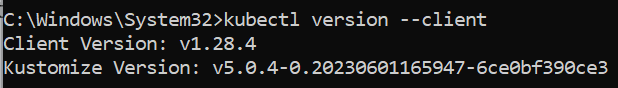

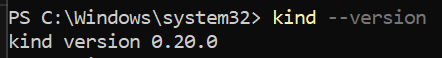

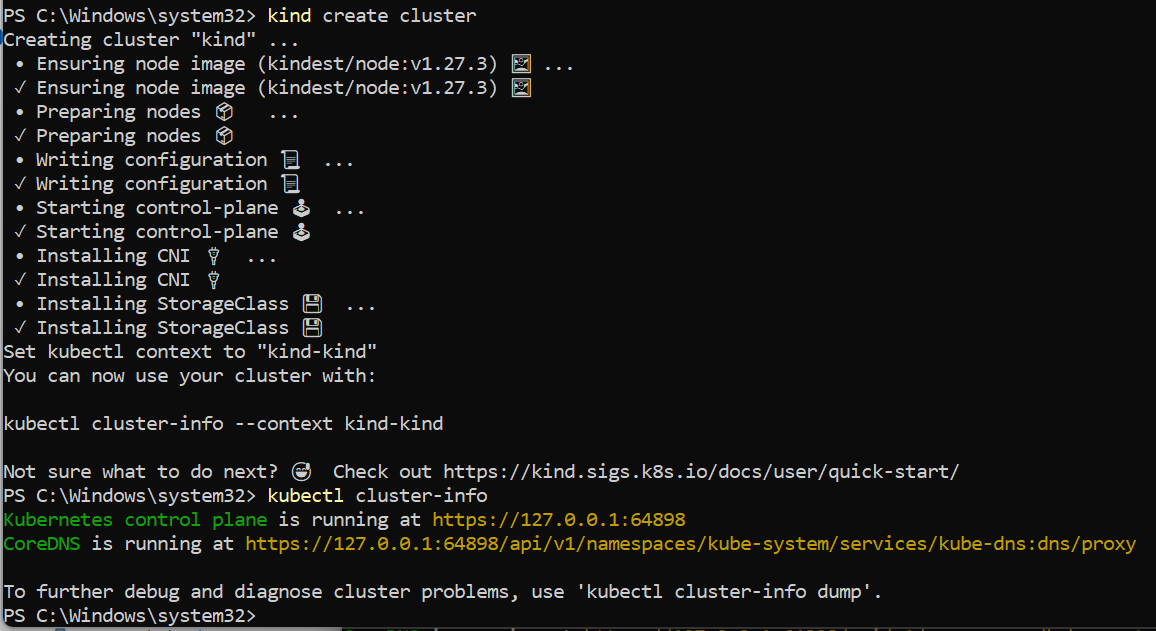

## Question 3

Now let's test if everything works. Use `kubectl` to get the list of running services. 

What's `CLUSTER-IP` of the service that is already running there? 

> **Answer:** 10.96.0.1 <br>
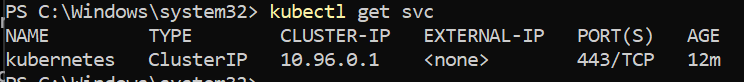



## Question 4

To be able to use the docker image we previously created (`zoomcamp-model:hw10`),
we need to register it with `kind`.

What's the command we need to run for that?

* `kind create cluster`
* `kind build node-image`
* `kind load docker-image`
* `kubectl apply`

> **Answer:** kind load docker-image <docker-image:tag>

## Question 5

Now let's create a deployment config (e.g. `deployment.yaml`):

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: credit
spec:
  selector:
    matchLabels:
      app: credit
  replicas: 1
  template:
    metadata:
      labels:
        app: credit
    spec:
      containers:
      - name: credit
        image: <Image>
        resources:
          requests:
            memory: "64Mi"
            cpu: "100m"            
          limits:
            memory: <Memory>
            cpu: <CPU>
        ports:
        - containerPort: <Port>
```

Replace `<Image>`, `<Memory>`, `<CPU>`, `<Port>` with the correct values.

What is the value for `<Port>`?  `Answer: 8500`

Apply this deployment using the appropriate command and get a list of running Pods. 
You can see one running Pod.

> - kind load docker-image zoomcamp-model:hw10
> - kubectl apply -f 05q-deployment.yaml
> - kubectl get pod

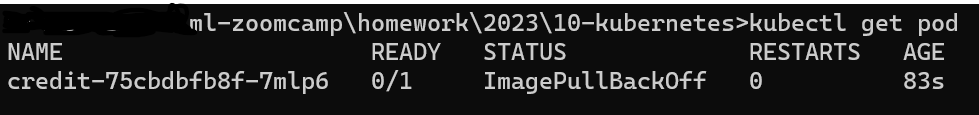

## Question 6

Let's create a service for this deployment (`service.yaml`):

```yaml
apiVersion: v1
kind: Service
metadata:
  name: <Service name>
spec:
  type: LoadBalancer
  selector:
    app: <???>
  ports:
  - port: 80
    targetPort: <PORT>
```

Fill it in. What do we need to write instead of `<???>`? <"Answer: credit">

Apply this config file.

## Testing the service

We can test our service locally by forwarding the port 9696 on our computer 
to the port 80 on the service:

```bash
kubectl port-forward service/<Service name> 9696:80
```

Run `q6_test.py` (from the homework 5) once again to verify that everything is working. 
You should get the same result as in Question 1.


## Autoscaling

Now we're going to use a [HorizontalPodAutoscaler](https://kubernetes.io/docs/tasks/run-application/horizontal-pod-autoscale-walkthrough/) 
(HPA for short) that automatically updates a workload resource (such as our deployment), 
with the aim of automatically scaling the workload to match demand.

Use the following command to create the HPA:

```bash
kubectl autoscale deployment credit --name credit-hpa --cpu-percent=20 --min=1 --max=3
```

You can check the current status of the new HPA by running:

```bash
kubectl get hpa
```

The output should be similar to the next:

```bash
NAME              REFERENCE                TARGETS   MINPODS   MAXPODS   REPLICAS   AGE
credit-hpa   Deployment/credit   1%/20%    1         3         1          27s
```

`TARGET` column shows the average CPU consumption across all the Pods controlled by the corresponding deployment.
Current CPU consumption is about 0% as there are no clients sending requests to the server.
> 
>Note: In case the HPA instance doesn't run properly, try to install the latest Metrics Server release 
> from the `components.yaml` manifest:
> ```bash
> kubectl apply -f https://github.com/kubernetes-sigs/metrics-server/releases/latest/download/components.yaml
>```


## Increase the load

Let's see how the autoscaler reacts to increasing the load. To do this, we can slightly modify the existing
`q6_test.py` script by putting the operator that sends the request to the credit service into a loop.

```python
while True:
    sleep(0.1)
    response = requests.post(url, json=client).json()
    print(response)
```

Now you can run this script.

## Question 7 (optional)

Run `kubectl get hpa credit-hpa --watch` command to monitor how the autoscaler performs. 
Within a minute or so, you should see the higher CPU load; and then - more replicas. 
What was the maximum amount of the replicas during this test?


* 1
* 2
* 3
* 4

> Note: It may take a few minutes to stabilize the number of replicas. Since the amount of load is not controlled 
> in any way it may happen that the final number of replicas will differ from initial.

## Submit the results

* Submit your results here: https://forms.gle/35gEVapd3uBoExFW7
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is **4 December 2022 (Monday), 23:00 CET (Berlin time)**. 

After that, the form will be closed.